Prepare Speakers Data

In [1]:
import pandas as pd
file = 'Speakers_by_session.csv'
speaker_df = pd.read_csv(file)

print(len(speaker_df))
print(speaker_df.columns)

7704
Index(['Year', 'Session', 'ISO Code', 'Country', 'Name of Person Speaking',
       'Post', 'Language', 'Notes'],
      dtype='object')


In [2]:
column_mapping = {
    'Year': 'year',
    'Session': 'session',
    'ISO Code': 'country',
    'Country': 'country_name',
    'Name of Person Speaking': 'speaker',
    'Post': 'position',
    'Language': 'language',
    'Notes': 'notes',
}

#select the new columns
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]

#select and rename columns
speaker_df = speaker_df[columns].rename(columns= column_mapping)

In [3]:
speaker_df

,year,session,country,country_name,speaker,position,language,notes
0,2015.0,70.0,AFG,Afghanistan,Mr. Abdullah Abdullah,Chief Executive Officer,English,NaN
1,2015.0,70.0,AGO,Angola,Mr. Manuel Domingos Vicente,vice-President,Portuguese,English text provided by the delegation
2,2015.0,70.0,ALB,Albania,Mr. Edi Rama,Prime minister,English,NaN
3,2015.0,70.0,AND,Andorra,Mr. Antoni Martí Petit,Head of Government,Catalan,Spanish text provided by the delegation
4,2015.0,70.0,ARE,United Arab Emirates,Sheikh Abdullah Bin Zayed Al Nahyan,Minister for Foreign Affairs,Arabic,NaN
...,...,...,...,...,...,...,...,...
7699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#SLV is not Slovenia, correct this:

speaker_df.loc[((speaker_df['session'] ==59) & (speaker_df['country_name']=='Slovenia')), 'country'] = 'SVN'

speaker_df[((speaker_df['session']==59) & (speaker_df['country_name']=='Slovenia'))] 

,year,session,country,country_name,speaker,position,language,notes
2269,2004.0,59.0,SVN,Slovenia,Mr. Janez Drnovšek,President,Slovenian,Spoke in Slovene; English text provided by the...


In [5]:
#create index on session and country for join with speeches df 

speaker_df.dropna(subset=['session','country'], inplace=True)

speaker_df.set_index(['session','country'], inplace=True, verify_integrity=True)

Prepare Speeches Data

In [6]:
file = 'un-general-debates.csv'

df = pd.read_csv(file)

print(len(df))

7507


In [7]:
#Generate standardized country names with pycountry:

import pycountry

def country_for_iso(iso):
    if iso =='YUG':
        return 'Yugoslavia'
    elif iso == 'CSK':
        return 'Czechoslovakia'
    elif iso == 'DDR':
        return 'German Dem. Republic'
    elif iso == 'YDYE':
        return 'Democratic Yemen'
    elif iso == 'EU':
        return 'European Union'
    else:
        return pycountry.countries.get(alpha_3=iso).name 

In [8]:
#align the two different Yemen codes

df['country_name'] = df['country'].apply(country_for_iso)

In [9]:
df.set_index(['session', 'country'], inplace=True, verify_integrity=True)

df.reset_index(inplace=True)

Join Speeches and Speakers

In [10]:
df = df.join(speaker_df, on = ['session','country'], rsuffix= '_spk')

df.columns
len(df)

7507

In [11]:
df = df[['session','year','country','country_name','speaker','position','position','text']]

df['session'] = df['session'].astype(int)
df['year'] = df['year'].astype(int)

df.sort_values(by = ['year','session','country'], inplace=True)


In [12]:
#save to csv

df.to_csv('un-general-debates-blueprint.csv.gz', index=False, compression='gzip')

In [13]:
file = 'un-general-debates-blueprint.csv.gz'

df = pd.read_csv(file)

Getting the Data Overview with Pandas

In [14]:
#calculate summary statistics
df['length'] = df['text'].str.len()

df.describe().T 

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [15]:
#for categorical data

df[['country','speaker']].describe(include='O').T

,count,unique,top,freq
country,7507,199,ALB,46
speaker,7480,5428,Seyoum Mesfin,12


We can see the dataset contains data from 199 unique countries(this is valid), and 5428 speakers, which is inaccurate.

Check for Missing Data

In [16]:
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
position.1      3005
text               0
length             0
dtype: int64

In [17]:
df['speaker'].fillna('unknown', inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_11248\1792866762.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['speaker'].fillna('unknown', inplace=True)


Sometimes the Speaker's name could be spelled differently or ambiguously

In [18]:
#compute number of records per speaker for all docs containing Bush in the speaker column

df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

speaker
George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: count, dtype: int64

Plot Value Distribution

<Axes: >

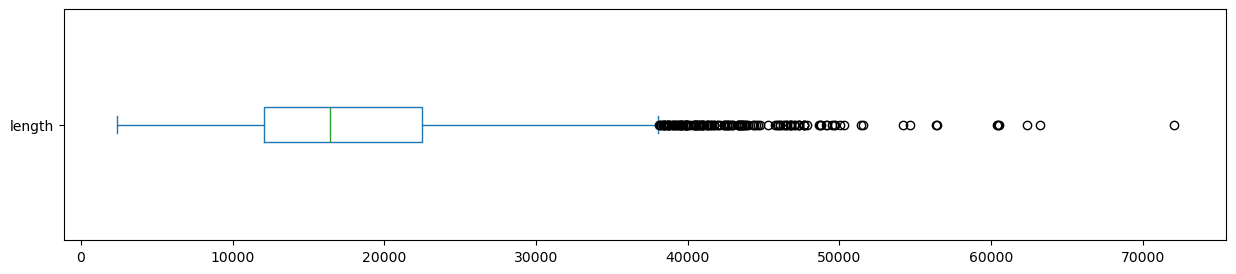

In [19]:
#plot a boxplot to visualize sumary of  a numerical distribution 

df['length'].plot(kind='box', vert =False, figsize=(15,3)) 

As illustrated, 50% of the speeches have a len btn roughly 12000 and 22,000 characters, with the median at about 16,000, and a long tail of outliers to the right. Distribution is left skewed. 

<Axes: ylabel='Frequency'>

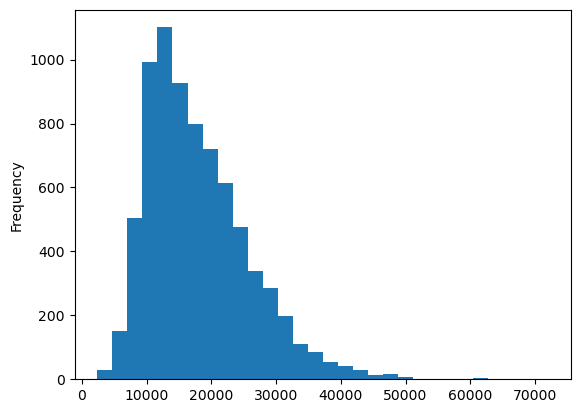

In [20]:
#plot a histogram

df['length'].plot(kind='hist', bins=30)

Compare Value Distributions Across Categories

We use seaborn to compare the distributions of the speech length of the five permanent UN members of the UN security council.

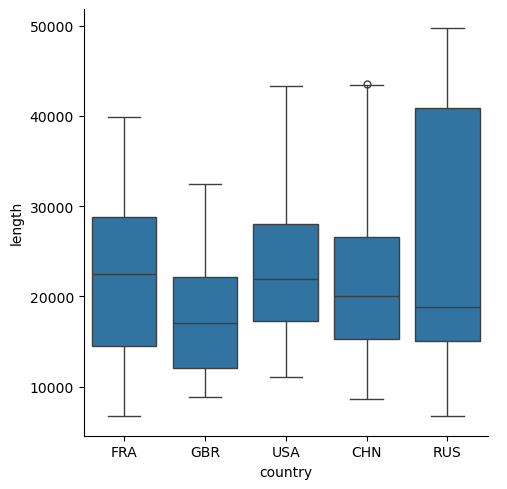

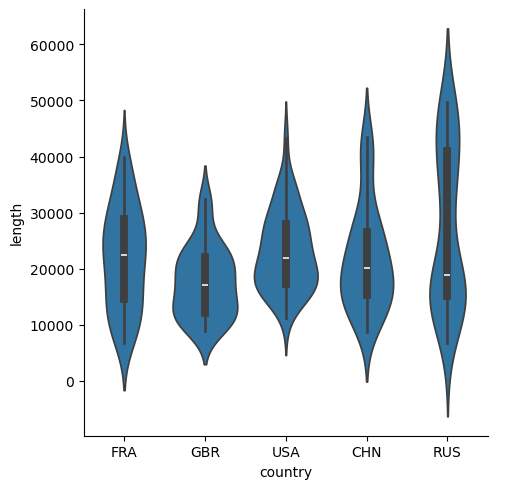

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])

sns.catplot(data=df[where], x='country', y='length', kind='box')
sns.catplot(data = df[where], x= 'country', y ='length', kind='violin')

The violin plot is a smoothed version of the boxplot. Frequencies are visualized by the width of the violin body, while the box is still visible inside the violin. In this case, the lengths of the speeches for Russia ais much larger than for Great Brtain but the existence of multiple peaks becomes apparent in the violin plot e.g., for Russia

<Figure size 800x200 with 0 Axes>

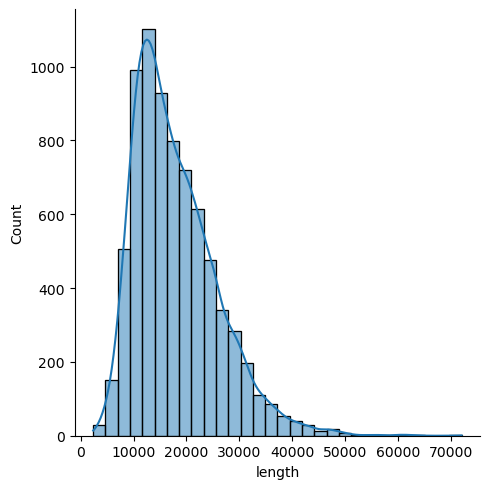

In [22]:
plt.figure(figsize= (8,2))
sns.displot(df['length'], bins=30, kde=True)

Visualizing Developments Over Time

<Axes: title={'center': 'Number of Countries'}, xlabel='year'>

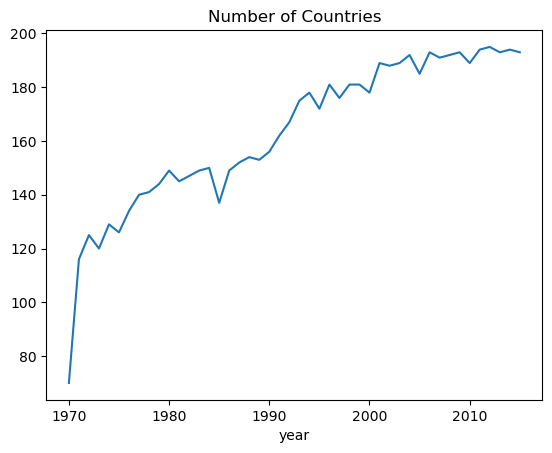

In [23]:
df.groupby('year').size().plot(title='Number of Countries')

The timeline above reflects the development of the number of countries in the UN. Whereas below, we can see that the speech length needed to decrease with more countries entering the debates.

<Axes: title={'center': 'Avg. Speech Length'}, xlabel='year'>

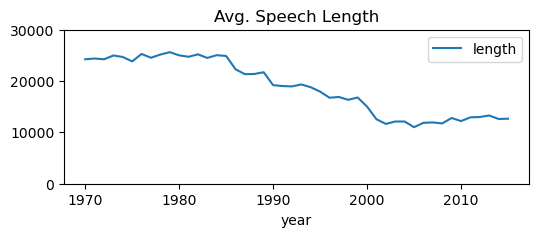

In [24]:
df.groupby('year').agg({'length': 'mean'}).plot(title='Avg. Speech Length', ylim=(0,30000), figsize=(6,2))

Blueprint: Building a Simple Text Preprocessing Pipeline

Tokenization with Regular Expressions

In [25]:
import regex as re

#the following expression matches tokens consisting of at least one letter({\p{L}),
# preceded and followed by an arbitrary sequence of alphanumeric characters(\w includes digits, letters, and underscores)

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)



In [26]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print('|'.join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


Treating Stop Words:

We work with NLTK's list of stopwords as our library

In [27]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [29]:
# tokens are converted to lowercase since NLTK's stopwords are all in lowercase.

def remove_stopwords(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

Often you’ll need to add domain-specific stop words to the predefined list. For example,
if you are analyzing emails, the terms dear and regards will probably appear in
almost any document.

In [30]:
#we can add and exclude stopword from the list using set operators: | which is (union/or), and - (difference)

include_stopwords = {'dear','regards', 'must', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

Processing a Pipeline with One Line of Code 

Create a new column containing the lowercased, tokenized text without stopwords for each document. 

In [31]:
pipeline = [str.lower, tokenize, remove_stopwords]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens 

In [32]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline) 

#the tokens column now consists of Py lists with the extracted tokens for each document 

In [33]:
#add another column containing the length of the token list for summarization later.

df['num_tokens'] = df['tokens'].map(len)

Blueprints for Word Frequency Analysis

Blueprint:Counting Words with a Counter

In [34]:
from collections import Counter

tokens = tokenize ('She likes my cats and my cats like my sofa.')

counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


The counter requires a list as input, so any text needs to be tokenized in advance, as shown above.
What’s nice about the counter is that it can be incrementally updated with a list of
tokens of a second document:

In [35]:
more_tokens = tokenize('she likes dogs and cats')
counter.update(more_tokens)
print(counter)

Counter({'my': 3, 'cats': 3, 'likes': 2, 'and': 2, 'She': 1, 'like': 1, 'sofa': 1, 'she': 1, 'dogs': 1})


To find the most frequent words within a corpus, we need to create a counter from
the list of all words in all documents, by using the update function of the counter object

In [36]:
counter = Counter()

df['tokens'].map(counter.update)

print(counter.most_common(5)) #top 5 most common tokens 

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421), ('countries', 85734)]


In [37]:
#we can transform the counter to a Pd.DF. 

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    
    #process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    #create counter and run through all data
    counter = Counter()
    df[column].map(update)

    #transform counter into a dataframe
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq']) #fequency values are stored in the new column 'freq'
    freq_df =freq_df.query('freq >= @min_freq') 
    freq_df.index.name = 'token' #the tokens make up the index of the dataframe 

    return freq_df.sort_values('freq', ascending=False)


#The function takes, as a first parameter, a Pandas DataFrame and takes the column name
# containing the tokens or the text as a second parameter.

In [38]:
#compute the dataframe with word frequencies and display top 5 tokens

freq_df = count_words(df)

freq_df.head(5)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


If we don’t want to use precomputed tokens for some special analysis, we could
tokenize the text on the fly with a custom preprocessing function as the third parameter, as shown:


In [39]:
count_words(df, column='text', preprocess = lambda text: re.findall(r'\w{10,}', text))

#last paramter defines a minimum frequency of tokens to be included in the result. Default is set to 2.

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177
...,...
enfranchising,2
interrelate,2
compositions,2


Blueprint: Creating a Frequency Diagram 

[Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Top Words in UN assembly speech')]

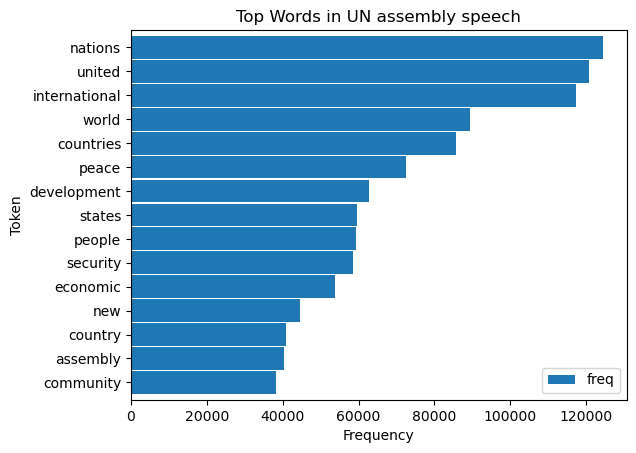

In [40]:
ax = freq_df.head(15).plot(kind='barh', width=0.95)
ax.invert_yaxis() #reverses the y axis
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words in UN assembly speech')

Blueprint: Creating Word Clouds

The wordcloud module generates nice word clouds from texts or counters. Instantiate a wordcloud object with some options and a stop word list, and then the cloud module handles the tokenization and stop word removal.

(-0.5, 399.5, 199.5, -0.5)

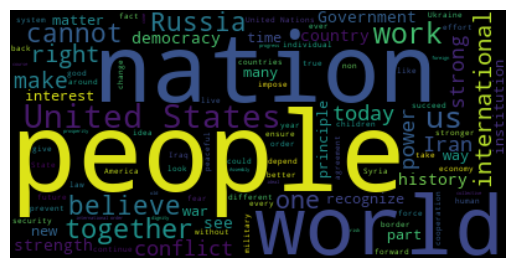

In [41]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text =df.query("year==2015 and country=='USA'")['text'].values[0]

wc =WordCloud(max_words=100, stopwords=stopwords) #we can ignore stating stopwords and it will just use the builtin default
wc.generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

The above does not work well for large datasets. For large datasets, we can create a frequency counter first and then use the function to generate_from_frequencies():

In [42]:
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400,
                   background_color='black', 
                   colormap='Paired',
                   max_font_size=150, 
                   max_words=max_words,
                   stopwords=stopwords)
    
    # Convert df to dict if necessary
    if isinstance(word_freq, pd.Series):
        word_freq = word_freq.to_dict()

    wc.generate_from_frequencies(word_freq)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()




The function has two convenience parameters to filter words. skip_n skips the top n
words of the list. 

The second filter is an (additional) list of stop words. Sometimes it is helpful to filter
out specific frequent but uninteresting words for the visualization only

In [43]:
freq_2015_df = count_words(df[df['year'] == 2015])
word_freq = freq_2015_df['freq']
print(word_freq) 

token
nations          2587
united           2571
development      1754
international    1727
world            1635
                 ... 
guatemalans         2
destroys            2
displaces           2
resignation         2
ammonium            2
Name: freq, Length: 8500, dtype: int64


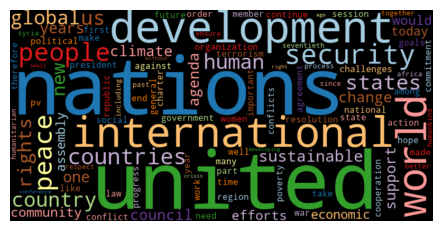

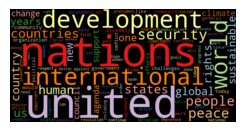

In [44]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
generate_wordcloud(word_freq, max_words=100)
plt.subplot(1, 2, 2)
generate_wordcloud(word_freq, max_words=100, stopwords=word_freq.head(50).index)


There are still unspecific and frequent words which need to be given less weight:

Blueprint: Ranking with TF-IDF (Inverse Document Frequency)

The inverse document frequency (IDF) is a weighting factor that measures the “unusualness”
of a term in a corpus. It is often used to reduce the influence of common
terms for data analysis or machine learning.

In [45]:
#define a function to compute all the words in the corpus and their idf values

import numpy as np 

def compute_idf(df, column='tokens', preprocess=None, min_df=2): 
#min_df serves as a filter for the long tail of infrequent words in the corpus 
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    #count tokens
    counter = Counter()
    df[column].map(update)

    #create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient = 'index', columns=['df'])
    idf_df = idf_df.query('df>@min_df') #filter out infrequent words
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+ 0.1 #compute idf 
    idf_df.index.name = 'token' #the tokens make up the index of the dataframe 
    return idf_df

#the IDF values are computed once for the entire corpus, do not use a subset 

In [46]:
#create a DF containing the IDF values for each token:

idf_df = compute_idf(df)

C:\Users\user\AppData\Local\Temp\ipykernel_11248\1476290443.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+ 0.1 #compute idf


In [47]:
#sample of IDF values. High IDF means rare(infrequent) terms in the corpus

idf_df.sample(5)

,df,idf
token,,
teeming,22,5.932549
ba,7,7.077681
opcw,12,6.538685
grants,193,3.760901
engineering,74,4.719526


In [48]:
#Both IDF and frequency DataFrames have an ndex consisting of the tokens. Multiply the columns
#of both DataFrames to get the TF-IDF score for the terms:

freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [49]:
#for more data, joining is faster instead:
#freq_df = freq_df.join(idf_df, lsuffix='_tf', rsuffix='_idf')  #added suffix to avoid name conflict with freq_df
#freq_df['tdif'] = freq_df['freq'] * freq_df['idf_idf']

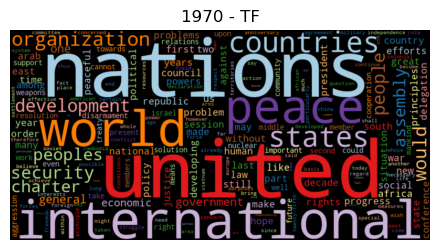

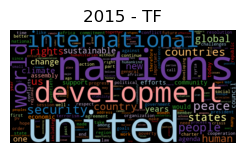

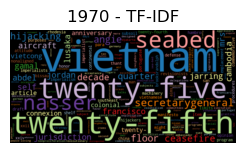

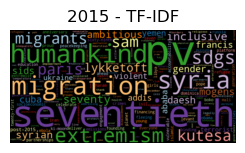

In [50]:
#we compare the word clouds based on word counts alone and TF-IDF scores for the speech 
#of the first and last layers in the corpus. We remove some more stopwords that stand for the numbers of the debate sessions

freq_1970 = count_words(df[df['year']==1970])
freq_2015 = count_words(df[df['year']==2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf'] 

plt.figure(figsize=(12, 6)) 

plt.subplot(2,2,1) 
generate_wordcloud(freq_1970['freq'], title='1970 - TF', stopwords=['twenty-fifth', 'twenty-five'])

plt.subplot(2,2,2)
generate_wordcloud(freq_2015['freq'], title= '2015 - TF', stopwords=['seventieth'])

plt.subplot(2,2,3)
generate_wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF', stopwords = ['tenty-fifth', 'twenty-five','twenty','fifth'])

plt.subplot(2,2,4)
generate_wordcloud(freq_2015['tfidf'], title = '2015 - TF-IDF', stopwords=['seventieth'])



Why not use vectorizers from the classes CountVectorizer and TfidfVectorizer for the above operations?

1. The vectorizers produce a vector with weighted term frequencies (tf) for each single document insteaf of arbitrary substes of the dataset.

2. The results are matrices which are good for ML and not dataframes which are good for slicing, aggregating, and visualization.

Blueprint: Finding a Keyword-in-Context Problem

In [51]:
import textacy

if textacy.__version__ < '0.11': # as in printed book
    from textacy.text_utils import KWIC
    
else: # for textacy 0.11.x
    from textacy.extract.kwic import keyword_in_context

    def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args, 
                           **{kw: arg for kw, arg in kwargs.items() 
                            if kw != 'print_only'})

TypeError: ForwardRef._evaluate() missing 1 required keyword-only argument: 'recursive_guard'

In [52]:
#KWIC is implemented in NLTK and textacy, but here we use textacy bc it is fast and works on untokenized text
import textacy
from textacy.extract.kwic import keyword_in_context 
import random 
import re 

def kwic(doc_series, keyword, window=35, print_samples=5): #window is the number of words before and after the keyword (right and left)
    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, window_width=window, print_only=False))
    
    kwic_list = []
    doc_series.map(add_kwic) #applies the function to each document in the series

    if print_samples is None or print_samples ==0:  #print samples limits number of random samples to print
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)}" + \
              f"contexts for '{keyword}':")
        
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0]) + ' ' + \
                  sample[1]+ ' '+\
                    re.sub(r'[\n\t]', ' ', sample[2])) 


#The re.sub() function is a regular expression substitution that replaces newline (\n) and tab (\t) characters with a space (' ')

#sample [1] is the keyword itself, sample[2] is the text after the KWIC context and sample[0] is the text before the KWIC context

TypeError: ForwardRef._evaluate() missing 1 required keyword-only argument: 'recursive_guard'

The above errors are due to a Python Compatibility issue with Spacy,due to updates on Py 3.12.4 to execute this code, run Python 3.11 and below, which has stable Spacy. 

By
default, the function returns a list of tuples of the form (left context, keyword,
right context). If print_samples is greater than 0, a random sample of the results
is printed. Sampling is useful when working with lots of documents
because the first entries of the list would otherwise stem from a single or a very small
number of documents

In [53]:
#The KWIC list for sdgs would be obtained by:

#kwic(df[df['year']==2015]['text'], 'sdgs', print_samples=5)

Blueprint: Analyzing N-Grams 

In text processing, we usually work with bigrams (sequences of length 2), sometimes
even trigrams (length 3). n-grams of size 1 are single words, also called unigrams. The
reason to stick to n ≤ 3 is that the number of different n-grams increases exponentially
with respect to n, while their frequencies decrease in the same way. By far the
most trigrams appear only once in a corpus.

In [55]:
def ngrams(tokens, n=2, sep= ' '):
    return[sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = 'the visible manifestation of the global climate change'
tokens = tokenize(text)
print('|'.join(ngrams(tokens, 2)))


the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


It's advisable to build bigrams without stopwords. But, we need to be
careful: if we remove the stop words first and then build the bigrams, we generate
bigrams that don’t exist in the original text as a “manifestation global” in the example statement.
Thus, we create the bigrams on all tokens but keep only those that do not contain any
stop words with this modified ngrams function:

In [56]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
           return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
                   if len([t for t in ngram if t in stopwords]) == 0]

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


Using the ngrams function, we can add a column containing all bigrams to our DataFrame and apply the wordcount blueprint to determine the top 5 bigrams:

In [57]:
df['bigrams'] = df['text'].apply(prepare, pipeline=[str.lower, tokenize]) \
    .apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


Notice that we ignored sentence boundaries during tokenization because we would have generated nonsense bigrams with the last word of one sentence and the
first word of the next. Those bigrams will not be very frequent, so they don’t really
matter for data exploration. If we wanted to prevent this, we would need to identify
sentence boundaries, which is much more complicated than word tokenization

C:\Users\user\AppData\Local\Temp\ipykernel_11248\1476290443.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+ 0.1 #compute idf


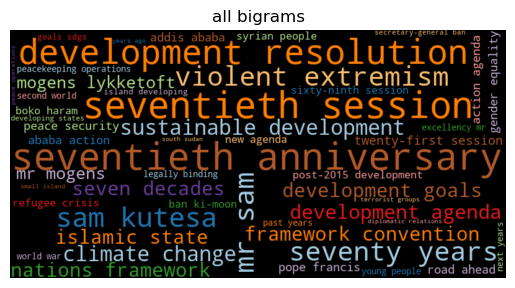

In [59]:
#let us extend our TF-IDF based unigram analysis from the previous code and include bigrams. 

#concatenate existing IDF DataFrame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year']==2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

generate_wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

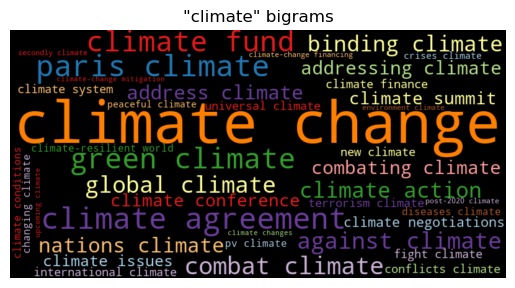

In [60]:
#to understand the diffeerent contexts of climate change, we can look at the bigrams that contain the word "climate"

where = freq_df.index.str.contains('climate')
generate_wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

Blueprint: Comparing Frequencies Across Time Intervals and Categories 

Creating Frequency Timelines

calculate the frequencies of given keywords per document and
then aggregate those frequencies using Pandas’s groupby function

In [61]:
#The following function is for extractng the counts of given keywords from a list of tokens:

def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

keywords = ['nuclear','terrorism','climate','freedom']
tokens = ['nuclear', 'climate','climate','freedom','climate', 'freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


The func above as seen, returns a list or vector of wordcounts. It's a simple count-vectorizer for keywords. Applying this func to every document in our DF get us a matrix of counts. 

In [68]:
def count_keywords_by(df, by, keywords, column='tokens'):

    freq_matrix = df[column].apply(count_keywords, keywords=keywords) #get a matrix of counts 
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords) #create a dataframe from matrix
    freq_df[by] = df[by] #copy the grouping columns 

    return freq_df.groupby(by=by).sum().sort_values(by) #sum and sort by grouping variable

In [69]:
freq_df = count_keywords_by(df, by='year', keywords = keywords)
freq_df.head(5)

,nuclear,terrorism,climate,freedom
year,,,,
1970,192,7,18,128
1971,275,9,35,205
1972,393,379,74,280
1973,347,124,79,266
1974,478,24,71,316


<Axes: title={'center': 'Keyword Count by Year'}, xlabel='year'>

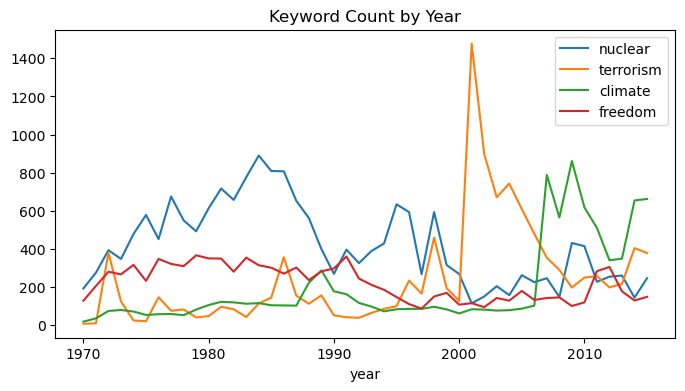

In [70]:
freq_df.plot(kind='line', figsize=(8,4), title='Keyword Count by Year')

In [72]:
freq_df = count_keywords_by(df, by='country', keywords = keywords)
freq_df.head(6)

,nuclear,terrorism,climate,freedom
country,,,,
AFG,124,137,14,48
AGO,42,38,42,27
ALB,66,75,25,201
AND,11,27,26,17
ARE,109,65,26,29
ARG,133,109,34,53


<Axes: title={'center': 'Keyword Count by Country'}, xlabel='country'>

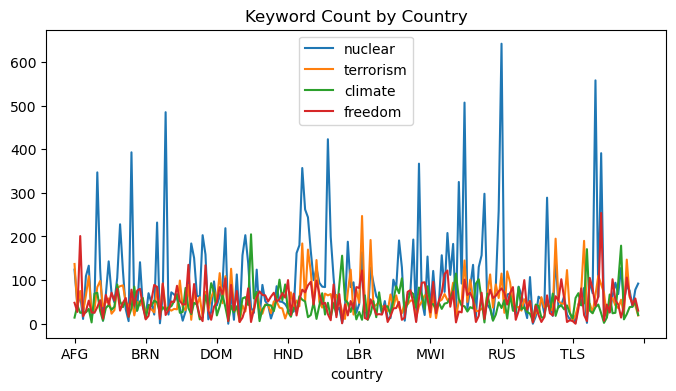

In [73]:
freq_df.plot(kind='line', figsize=(8,4), title='Keyword Count by Country')

Creating Frequency Heatmaps 

<Axes: xlabel='year'>

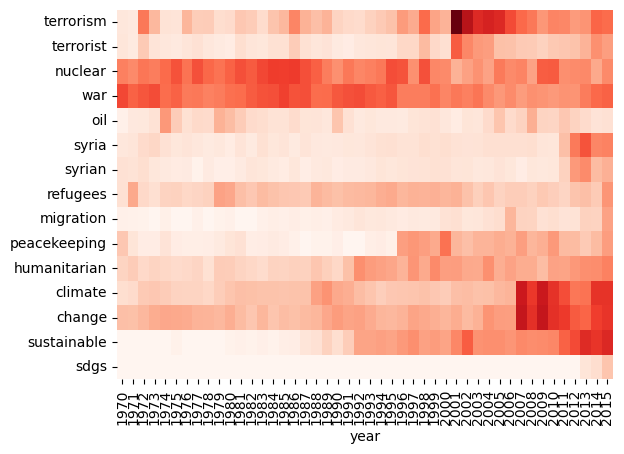

In [74]:
#a good replacement for linecharts. Linecharts become confusing if there are too many data points/lines

keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil', 'syria', 'syrian',
             'refugees', 'migration', 'peacekeeping', 'humanitarian', 'climate', 
             'change','sustainable','sdgs']

freq_df = count_keywords_by(df, by='year', keywords=keywords)

#compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0) 

#apply Sq. root as sublinear filter for better contrast 
freq_df = freq_df.apply(np.sqrt) 

sns.heatmap(data=freq_df.T, xticklabels=True, yticklabels=True, cbar=False, cmap='Reds')


A few things to consider about this kind of analysis:

1. Prefer relative frequencies for any kind of comparison - Absolute term frequencies are problematic if the total number of tokens per year or category is not stable. 

2. Be careful with the interpretation of frequency diagrams based on keyword lists - keywords may have different meanings. There may also be other words representing the same topic but not included in the list

3. Use sublinear scaling - As the frequency values differ greatly, it may be hard to see any change for lessfrequent
tokens. Therefore, you should scale the frequencies sublinearly (we
applied the square root np.sqrt). The visual effect is similar to lowering contrast